<a href="https://colab.research.google.com/github/pachterlab/MBGBLHGP_2019/blob/master/notebooks/lamanno_velocity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Fri May 17 00:21:00 PDT 2019


In [2]:
!git clone https://github.com/pachterlab/MBGBLHGP_2019.git

Cloning into 'MBGBLHGP_2019'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 864 (delta 7), reused 30 (delta 7), pack-reused 831
Receiving objects: 100% (864/864), 2.68 GiB | 43.10 MiB/s, done.
Resolving deltas: 100% (232/232), done.
Checking out files: 100% (380/380), done.


# Produce Figure X for kallisto bus paper

We are using the fastqs made from the BAM file of SRR6470906 and SRR6470907

In [1]:
!yes | pip install --quiet scanpy loompy scvelo velocyto anndata

     |████████████████████████████████| 10.3MB 4.9MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 225kB 47.3MB/s 
     |████████████████████████████████| 204kB 46.2MB/s 
     |████████████████████████████████| 122kB 42.0MB/s 
     |████████████████████████████████| 112kB 45.6MB/s 
     |████████████████████████████████| 10.0MB 25.4MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 


In [3]:
!gunzip -r /content/MBGBLHGP_2019/data/lamanno_velocity/*

In [4]:
import pandas as pd
import scanpy as sc
import numpy as np
import scipy as scp
import sklearn
import matplotlib.pyplot as plt
import matplotlib
import sys
import loompy
import scipy.optimize
import velocyto as vcy
import scvelo as scv
import glob
import pickle
import anndata

from collections import Counter
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))
matplotlib.rcParams.update({'font.size': 22})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.6/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## Import reference matrices

In [5]:
them = scv.read('/content/MBGBLHGP_2019/data/lamanno_velocity/hgForebrainGlut.loom', cleanup=True, sparse=True, cache=True, backup_url='http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom')
them.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


## Import spliced and unspliced matrices from the kallisto workflow

In [6]:
%%time
spliced06   = "/content/MBGBLHGP_2019/data/lamanno_velocity/06/gc_cDNA/"
unspliced06 = "/content/MBGBLHGP_2019/data/lamanno_velocity/06/gc_introns/"

s06 = sc.read_mtx(spliced06 + "s.mtx")
u06 = sc.read_mtx(unspliced06 + "u.mtx")

s_bcs06 = pd.read_csv(spliced06 + "s.barcodes.txt", header=None)
u_bcs06 = pd.read_csv(unspliced06 + "u.barcodes.txt", header=None)

s_genes06 = pd.read_csv(spliced06 + "s.genes.txt", header=None)
u_genes06 = pd.read_csv(unspliced06 + "u.genes.txt", header=None)

s06.obs.index = s_bcs06[0].values
u06.obs.index = u_bcs06[0].values

s06.var.index = s_genes06[0].values
u06.var.index = u_genes06[0].values

del s_bcs06
del u_bcs06
del s_genes06
del u_genes06

CPU times: user 55.2 s, sys: 1.03 s, total: 56.2 s
Wall time: 56.3 s


In [7]:
%%time
spliced07   = "/content/MBGBLHGP_2019/data/lamanno_velocity/07/gc_cDNA/"
unspliced07 = "/content/MBGBLHGP_2019/data/lamanno_velocity/07/gc_introns/"

s07 = sc.read_mtx(spliced07 + "s.mtx")
u07 = sc.read_mtx(unspliced07 + "u.mtx")

s_bcs07 = pd.read_csv(spliced07 + "s.barcodes.txt", header=None)
u_bcs07 = pd.read_csv(unspliced07 + "u.barcodes.txt", header=None)

s_genes07 = pd.read_csv(spliced07 + "s.genes.txt", header=None)
u_genes07 = pd.read_csv(unspliced07 + "u.genes.txt", header=None)

s07.obs.index = s_bcs07[0].values
u07.obs.index = u_bcs07[0].values

s07.var.index = s_genes07[0].values
u07.var.index = u_genes07[0].values

del s_bcs07
del u_bcs07
del s_genes07
del u_genes07

CPU times: user 1min 14s, sys: 1.68 s, total: 1min 16s
Wall time: 1min 16s


In [8]:
s = scp.sparse.vstack([s06.X, s07.X])
u = scp.sparse.vstack([u06.X, u07.X])

In [9]:
s_bcs06["sample"] = "06"
s_bcs07["sample"] = "07"

u_bcs06["sample"] = "06"
u_bcs07["sample"] = "07"

In [10]:
s_bcs06.columns = ["bcs", "sample"]
s_bcs07.columns = ["bcs", "sample"]

u_bcs06.columns = ["bcs", "sample"]
u_bcs07.columns = ["bcs", "sample"]

In [11]:
s_bcs06.index = s_bcs06["bcs"] + "." + s_bcs06["sample"]
s_bcs07.index = s_bcs07["bcs"] + "." + s_bcs07["sample"]

u_bcs06.index = u_bcs06["bcs"] + "." + u_bcs06["sample"]
u_bcs07.index = u_bcs07["bcs"] + "." + u_bcs07["sample"]

In [12]:
s_bcs = pd.concat([s_bcs06, s_bcs07],ignore_index=False)
u_bcs = pd.concat([u_bcs06, u_bcs07],ignore_index=False)

In [13]:
genes = s_genes06
genes.columns=["gid"]

In [14]:
sadata = anndata.AnnData(X=s, obs=s_bcs, var=genes)
uadata = anndata.AnnData(X=u, obs=u_bcs, var=genes)

In [15]:
print(sadata)
print(uadata)

AnnData object with n_obs × n_vars = 588330 × 64792
    obs: 'bcs', 'sample'
    var: 'gid'
AnnData object with n_obs × n_vars = 395178 × 64792
    obs: 'bcs', 'sample'
    var: 'gid'


In [16]:
t2g = pd.read_csv("/content/MBGBLHGP_2019/data/lamanno_velocity/human.gencodeV29.t2g.no_version.txt", header=None, sep="\t", names=["tid", "gid", "gene"])
t2g = t2g.drop_duplicates(["gid", "gene"])
t2g = t2g.set_index("gid")

In [18]:
them.obs["bcs"] = them.obs.index.str.slice(11,-1)

28 <-> 07, 29 <-> 06

In [19]:
them.obs["bid"] = them.obs.index.str.slice(8,10)

In [20]:
them.obs["sample"] = them.obs.bid.map(lambda x: "06" if x=="29" else "07")

In [21]:
them.obs.head()

Clusters               bcs bid sample
10X_17_028:AACCATGGTAATCACCx         3  AACCATGGTAATCACC  28     07
10X_17_028:AACCATGCATACTACGx         3  AACCATGCATACTACG  28     07
10X_17_028:AAACCTGGTAAAGGAGx         1  AAACCTGGTAAAGGAG  28     07
10X_17_028:AAAGTAGCAAAGTCAAx         0  AAAGTAGCAAAGTCAA  28     07
10X_17_028:AAAGCAACAAACGCGAx         3  AAAGCAACAAACGCGA  28     07

In [22]:
them.obs.index = them.obs.bcs.values + "."+ them.obs["sample"]

In [23]:
print(sadata)
print(uadata)
print(them)

AnnData object with n_obs × n_vars = 588330 × 64792
    obs: 'bcs', 'sample'
    var: 'gid'
AnnData object with n_obs × n_vars = 395178 × 64792
    obs: 'bcs', 'sample'
    var: 'gid'
AnnData object with n_obs × n_vars = 1720 × 32738
    obs: 'Clusters', 'bcs', 'bid', 'sample'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'


## Select the barcodes/genes for s and u by those in them

In [24]:
sadata = sadata[sadata.obs.index.isin(them.obs.index),:]
uadata = uadata[uadata.obs.index.isin(them.obs.index),:]
sadata = sadata[:,sadata.var.gid.isin(them.var.Accession)]
uadata = uadata[:,uadata.var.gid.isin(them.var.Accession)]

In [25]:
print(sadata)
print(uadata)
print(them)

View of AnnData object with n_obs × n_vars = 1720 × 31114
    obs: 'bcs', 'sample'
    var: 'gid'
View of AnnData object with n_obs × n_vars = 1720 × 31114
    obs: 'bcs', 'sample'
    var: 'gid'
AnnData object with n_obs × n_vars = 1720 × 32738
    obs: 'Clusters', 'bcs', 'bid', 'sample'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'


In [26]:
sadata = sadata[sadata.obs.index.isin(uadata.obs.index),:]
uadata = uadata[uadata.obs.index.isin(sadata.obs.index),:]

In [27]:
print(sadata)
print(uadata)
print(them)

View of AnnData object with n_obs × n_vars = 1720 × 31114
    obs: 'bcs', 'sample'
    var: 'gid'
View of AnnData object with n_obs × n_vars = 1720 × 31114
    obs: 'bcs', 'sample'
    var: 'gid'
AnnData object with n_obs × n_vars = 1720 × 32738
    obs: 'Clusters', 'bcs', 'bid', 'sample'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'


## Make annotated dataframe for the kallisto matrices
This involves making a blank ambiguous matrix (since the current implementation of kallisto does not produce an ambiguous matrix), transferring the cluster IDs, and formatting the adata so that the velocyto jupyter notebook can process it.

In [60]:
%%time
adata = sadata.copy()

adata.layers["spliced"] = sadata.X
adata.layers["unspliced"] = uadata.X
adata.layers["ambiguous"] = scp.sparse.csr_matrix(np.zeros(adata.X.shape))

adata.obs = sadata.obs
adata.var.index = sadata.var.gid

adata.obs["CellID"] = adata.obs.index
adata.obs["Clusters"] = adata.obs.index.map(them.obs["Clusters"])
adata.var["Gene"] = adata.var.index.map(t2g["gene"])
adata.var["Accession"] = adata.var.index
adata.var = adata.var.set_index("Gene")

CPU times: user 497 ms, sys: 403 ms, total: 900 ms
Wall time: 906 ms


In [61]:
adata.obs.head()

bcs sample               CellID  Clusters
AAACGGGAGATTACCC.06  AAACGGGAGATTACCC     06  AAACGGGAGATTACCC.06         6
AAACGGGTCGCTAGCG.06  AAACGGGTCGCTAGCG     06  AAACGGGTCGCTAGCG.06         5
AAATGCCTCTAACTCT.06  AAATGCCTCTAACTCT     06  AAATGCCTCTAACTCT.06         4
AACACGTAGGTAGCCA.06  AACACGTAGGTAGCCA     06  AACACGTAGGTAGCCA.06         5
AACACGTCATTACGAC.06  AACACGTCATTACGAC     06  AACACGTCATTACGAC.06         5

In [62]:
scv.pp.show_proportions(adata)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.55 0.45]
AnnData object with n_obs × n_vars = 1720 × 31114
    obs: 'bcs', 'sample', 'CellID', 'Clusters'
    var: 'gid', 'Accession'
    layers: 'spliced', 'unspliced', 'ambiguous'


## Save the adata as a loom file so it can be ran in the Veloctyo Python pipeline

In [63]:
adata.write_loom("./test_kallisto.loom")

# Run the Velocyto Python pipeline

In [64]:
import logging
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)

## These are helper functions

In [65]:
# Wrap implementation
import rpy2.robjects as robj
from rpy2.robjects.packages import importr

def array_to_rmatrix(X):
    nr, nc = X.shape
    xvec = robj.FloatVector(X.transpose().reshape((X.size)))
    xr = robj.r.matrix(xvec, nrow=nr, ncol=nc)
    return xr

def principal_curve(X, pca=True):
    """
    input : numpy.array
    returns:
    Result::Object
        Methods:
        projections - the matrix of the projectiond
        ixsort - the order ot the points (as in argsort)
        arclength - the lenght of the arc from the beginning to the point
    """
    # convert array to R matrix
    xr = array_to_rmatrix(X)
    
    if pca:
        #perform pca
        t = robj.r.prcomp(xr)
        #determine dimensionality reduction
        usedcomp = max( sum( np.array(t[t.names.index('sdev')]) > 1.1) , 4)
        usedcomp = min([usedcomp, sum( np.array(t[t.names.index('sdev')]) > 0.25), X.shape[0]])
        Xpc = np.array(t[t.names.index('x')])[:,:usedcomp]
        # convert array to R matrix
        xr = array_to_rmatrix(Xpc)

    #import the correct namespace
    princurve = importr("princurve", on_conflict="warn")
    
    #call the function
    fit1 = princurve.principal_curve(xr)
    
    #extract the outputs
    class Results:
        pass
    results = Results()
    results.projections = np.array( fit1[0] )
    results.ixsort = np.array( fit1[1] ) - 1 # R is 1 indexed
    results.arclength = np.array( fit1[2] )
    results.dist = np.array( fit1[3] )
    
    if pca:
        results.PCs = np.array(xr) #only the used components
        
    return results

In [66]:
# princurve = importr("princurve", on_conflict="warn")

## Load the loom file

In [67]:
vlm = vcy.VelocytoLoom("./test_kallisto.loom")

In [68]:
# Load an initial clustering (Louvein)
labels = vlm.ca["Clusters"]
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
vlm.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})

## Velocity Analysis

In [69]:
# just to find the initial cell size
vlm.normalize("S", size=True, log=False)
vlm.normalize("U", size=True,  log=False)

In [70]:
vlm.score_detection_levels(min_expr_counts=30, min_cells_express=20,
                           min_expr_counts_U=0, min_cells_express_U=0)
vlm.filter_genes(by_detection_levels=True)

2021-02-06 06:14:55,315 - DEBUG - Filtering by detection level


2021-02-06 06:14:59,520 - DEBUG - Filtering by cv vs mean


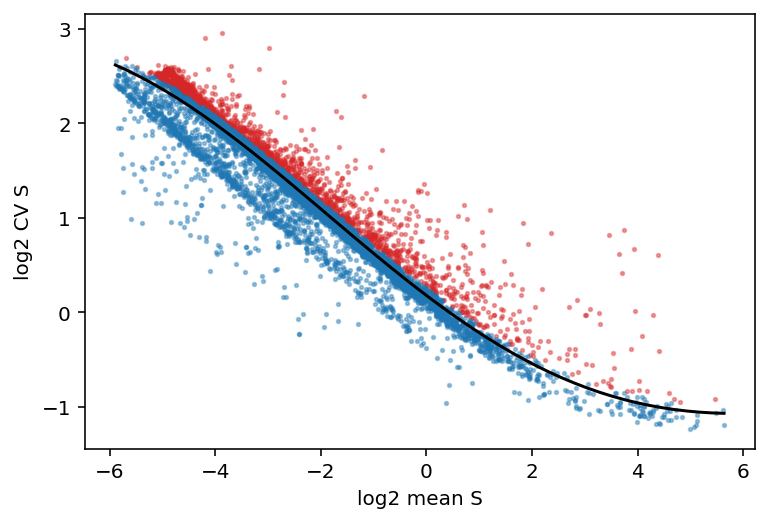

In [71]:
vlm.score_cv_vs_mean(2000, plot=True, max_expr_avg=50, winsorize=True, winsor_perc=(1,99.8), svr_gamma=0.01, min_expr_cells=50)
vlm.filter_genes(by_cv_vs_mean=True)

In [72]:
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0,
                           min_expr_counts_U=25, min_cells_express_U=20)
vlm.score_cluster_expression(min_avg_U=0.007, min_avg_S=0.06)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)
vlm.normalize_by_total(min_perc_U=0.5)
vlm.adjust_totS_totU(normalize_total=True, fit_with_low_U=False, svr_C=1, svr_gamma=1e-04)

2021-02-06 06:15:03,958 - INFO - Cluster: 0 (187 cells)
2021-02-06 06:15:03,971 - INFO - Cluster: 1 (332 cells)
2021-02-06 06:15:03,991 - INFO - Cluster: 2 (94 cells)
2021-02-06 06:15:03,999 - INFO - Cluster: 3 (249 cells)
2021-02-06 06:15:04,015 - INFO - Cluster: 4 (347 cells)
2021-02-06 06:15:04,035 - INFO - Cluster: 5 (243 cells)
2021-02-06 06:15:04,051 - INFO - Cluster: 6 (268 cells)
2021-02-06 06:15:04,069 - DEBUG - Filtering by cluster expression
2021-02-06 06:15:04,070 - DEBUG - Filtering by detection level


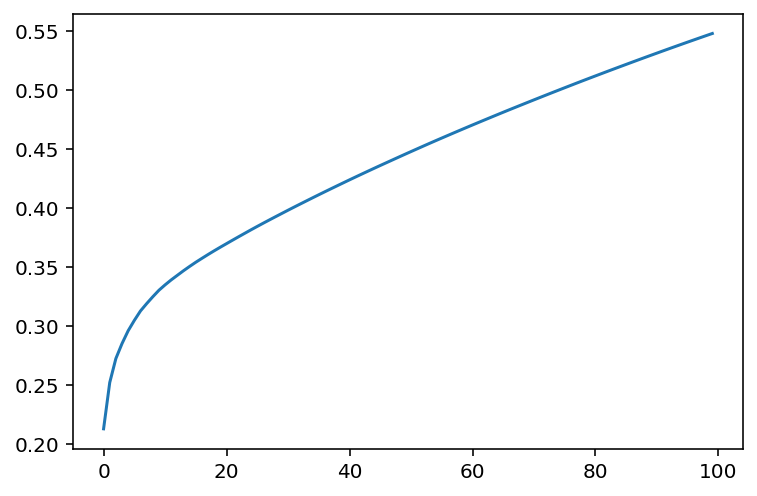

In [73]:
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.0055))[0][0]
vlm.pcs[:,1] *= -1 # flip for consistency with previous version

In [45]:
!yes  | pip install --quiet python-igraph 

     |████████████████████████████████| 3.2MB 5.6MB/s 


In [74]:
from sklearn.neighbors import NearestNeighbors
import igraph
nn = NearestNeighbors(50)
nn.fit(vlm.pcs[:,:4])
knn_pca = nn.kneighbors_graph(mode='distance')
knn_pca = knn_pca.tocoo()
G = igraph.Graph(list(zip(knn_pca.row, knn_pca.col)), directed=False, edge_attrs={'weight': knn_pca.data})
VxCl = G.community_multilevel(return_levels=False, weights="weight")
labels = np.array(VxCl.membership)

In [75]:
from numpy_groupies import aggregate, aggregate_np

In [77]:
# pc_obj = principal_curve(vlm.pcs[:,:4], False)
# pc_obj.arclength = np.max(pc_obj.arclength) - pc_obj.arclength
# labels = np.argsort(np.argsort(aggregate_np(labels, pc_obj.arclength, func=np.median)))[labels]

In [78]:
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
vlm.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})

In [79]:
k = 550
vlm.knn_imputation(n_pca_dims=n_comps,k=k)

In [80]:
vlm.normalize_median()
vlm.fit_gammas(maxmin_perc=[2,95], limit_gamma=True)

In [81]:
vlm.normalize(which="imputed", size=False, log=True)
vlm.Pcs = np.array(vlm.pcs[:,:2], order="C")

In [82]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift()
vlm.extrapolate_cell_at_t(delta_t=1)

In [83]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1,
                             n_neighbors=150, knn_random=True, sampled_fraction=1)

2021-02-06 06:15:59,635 - DEBUG - label 0:
    value = arg(0, name=value)               ['value']
    $0.1 = global(np: <module 'numpy' from '/usr/local/lib/python3.6/dist-packages/numpy/__init__.py'>) ['$0.1']
    $0.2 = getattr(value=$0.1, attr=random)  ['$0.1', '$0.2']
    $0.3 = getattr(value=$0.2, attr=seed)    ['$0.2', '$0.3']
    $0.5 = call $0.3(value, func=$0.3, args=[Var(value, analysis.py:2415)], kws=(), vararg=None) ['$0.3', '$0.5', 'value']
    $const0.6 = const(NoneType, None)        ['$const0.6']
    $0.7 = cast(value=$const0.6)             ['$0.7', '$const0.6']
    return $0.7                              ['$0.7']

2021-02-06 06:15:59,647 - DEBUG - ==== SSA block analysis pass on 0
2021-02-06 06:15:59,648 - DEBUG - Running <numba.core.ssa._GatherDefsHandler object at 0x7ff96f1307b8>
2021-02-06 06:15:59,652 - DEBUG - on stmt: value = arg(0, name=value)
2021-02-06 06:15:59,657 - DEBUG - on stmt: $0.1 = global(np: <module 'numpy' from '/usr/local/lib/python3.6/dist-package

In [84]:
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)

2021-02-06 06:17:24,097 - DEBUG - Calculate transition probability
2021-02-06 06:17:24,165 - DEBUG - Calculate transition probability for negative control


In [85]:
vlm.calculate_grid_arrows(smooth=0.9, steps=(25, 25), n_neighbors=200)

2021-02-06 06:17:37,042 - WARNING - The arrow scale was set to be 'absolute' make sure you know how to properly interpret the plots


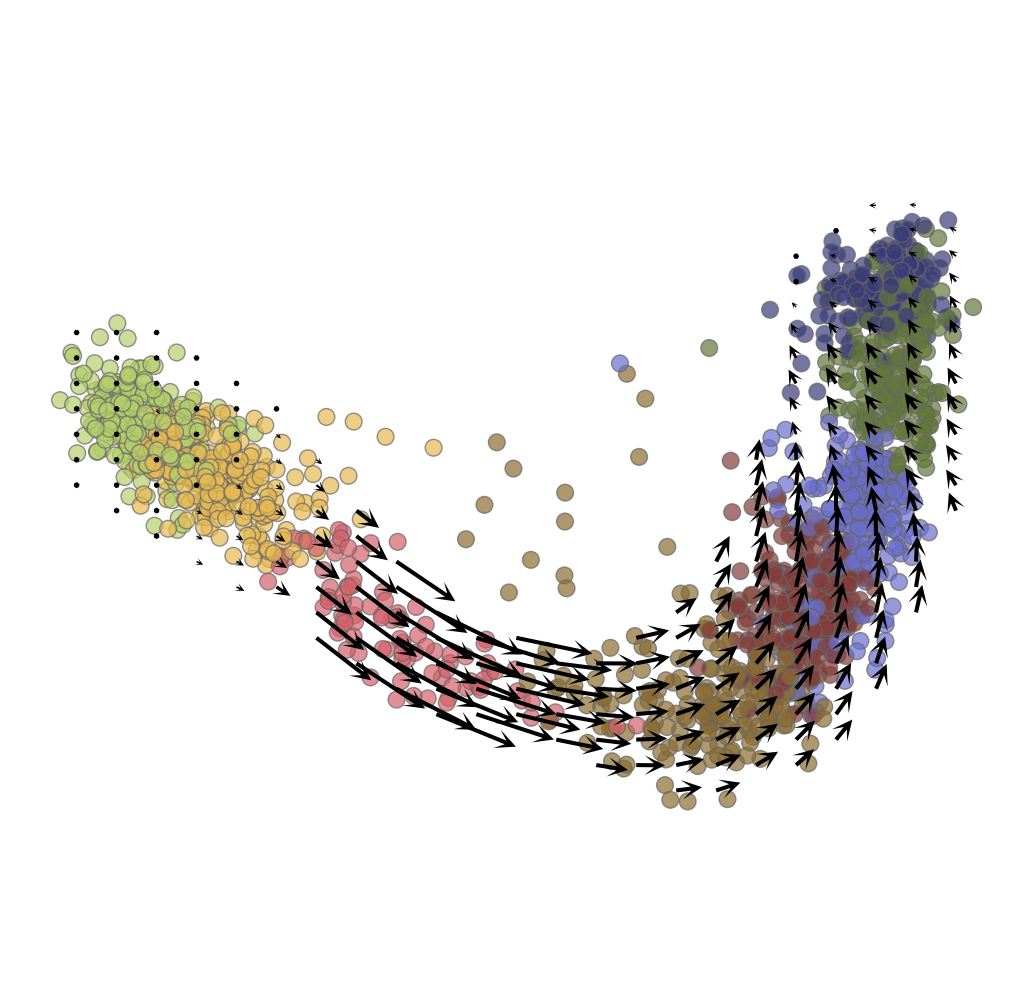

In [87]:
plt.figure(None,(9,9))
vlm.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":True},
                     min_mass=2.9, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.35, scale_type="absolute")
# plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="w", lw=6, zorder=1000000)
# plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="k", lw=3, zorder=2000000)
plt.gca().invert_xaxis()
plt.axis("off")
plt.axis("equal");
plt.savefig("kallisto_velocity_forebrain_glut.pdf")

## Plot level of expression by max proj

In [88]:
ds = loompy.connect("test_kallisto.loom")

In [89]:
from matplotlib.colors import LinearSegmentedColormap
def scatter_lev(x, y, score, *args, **kwargs):
    ix_x_sort = np.argsort(score, kind="mergesort")
    ix_yx_sort = ix_x_sort
    args_new = []
    kwargs_new = {}
    for arg in args:
        if type(arg) is np.ndarray:
            args_new.append(arg[ix_x_sort][ix_yx_sort])
        else:
            args_new.append(arg)
    for karg, varg in kwargs.items():
        if type(varg) is np.ndarray:
            kwargs_new[karg] = varg[ix_x_sort][ix_yx_sort]
        else:
            kwargs_new[karg] = varg
    ax = plt.scatter(x[ix_x_sort][ix_yx_sort], y[ix_x_sort][ix_yx_sort], *args_new, **kwargs_new)
    return ax

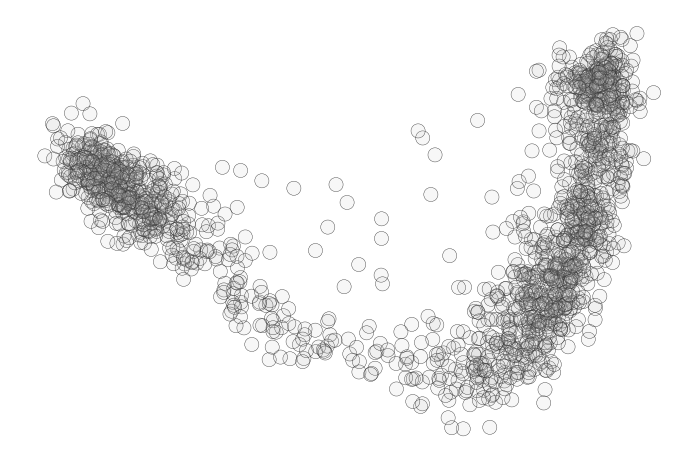

In [90]:
#list_genes = np.array(["SOX2", "EOMES", "SLC17A7"])
list_genes = np.array(["ENSG00000181449", "ENSG00000163508", "ENSG00000104888"])
list_colors = [[104,254,246,255], [251,243,66,255], [203,38,229,255]]
list_colors = np.array([np.array(i)/255 for i in list_colors])

# Extract level of expression
list_xs = []
list_s = []
for gene in list_genes:
    x = ds.layer["spliced"][np.where(ds.row_attrs["Accession"][:] == gene)[0][0], :]
    x = np.mean(vlm.initial_cell_size) * x / vlm.initial_cell_size
    list_s.append(x)
list_s = np.array(list_s)
scal_s = list_s / np.percentile(list_s, 98, 1)[:,None]
max_s = np.argmax(scal_s, 0)

# Make color Array
clarr = np.zeros((max_s.shape[0], 4))
clscore= np.zeros((max_s.shape[0]))
for i in range(len(list_genes)):
    base = (list_colors[i] + np.array([0.6,0.6,0.6, 0.3])) / 2.
    color_gene = LinearSegmentedColormap.from_list(f"color_{list_genes[i]}" , [base, list_colors[i]], )
    sel = (max_s==i) & (scal_s[i] > 0.45)
    clarr[(max_s==i), :] = np.array([0.7,0.7,0.7, 0.1])
    clarr[sel, :] = color_gene(np.log(scal_s[i]+1))[sel]
    clscore[sel] = np.log(scal_s[i]+1)[sel]
    
scatter_lev(-vlm.pcs[:,0], vlm.pcs[:,1], score=clarr[:,-1], c=clarr, s=50, lw=0.2, edgecolor="0.2", rasterized=True)

plt.axis("off");

# Plot different dynamics

Filter genes that peak at the different timepoints removing the ones that show low correlation between velocity and expression

# Run the scvelo pipeline

In [92]:
adata = scv.read("test_kallisto.loom", sparse=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Process the data

In [93]:
adata.obs["clusters"] = adata.obs["Clusters"]

In [94]:
scv.pp.filter_and_normalize(adata, min_counts=40, min_counts_u=20, n_top_genes=3000)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 21525 genes that are detected 40 counts (spliced).
Filtered out 1794 genes that are detected 20 counts (unspliced).
Exctracted 3002 highly variable genes.
Logarithmized X.


In [95]:
scv.pp.moments(adata)

Streaming output truncated to the last 5000 lines.
2021-02-06 06:21:27,670 - DEBUG - find_def_from_bottom label 450
2021-02-06 06:21:27,671 - DEBUG - incoming_def mid.2 = $450.3
2021-02-06 06:21:27,673 - DEBUG - find_def_from_bottom label 418
2021-02-06 06:21:27,674 - DEBUG - incoming_def mid.1 = $418.6
2021-02-06 06:21:27,675 - DEBUG - find_def_from_bottom label 460
2021-02-06 06:21:27,676 - DEBUG - incoming_def mid.3 = $460.5
2021-02-06 06:21:27,677 - DEBUG - incoming_def mid.5 = phi(incoming_values=[Var(mid.2, umap_.py:236), Var(mid.1, umap_.py:232), Var(mid.3, umap_.py:238)], incoming_blocks=[450, 418, 460])
2021-02-06 06:21:27,678 - DEBUG - find_def_from_bottom label 282
2021-02-06 06:21:27,679 - DEBUG - find_def_from_top label 282
2021-02-06 06:21:27,680 - DEBUG - idom 280 from label 282
2021-02-06 06:21:27,684 - DEBUG - find_def_from_bottom label 280
2021-02-06 06:21:27,685 - DEBUG - find_def_from_top label 280
2021-02-06 06:21:27,685 - DEBUG - idom 92 from label 280
2021-02-06 

2021-02-06 06:21:50,646 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=bold:stretch=normal:size=40.0.
2021-02-06 06:21:50,652 - DEBUG - findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.335
2021-02-06 06:21:50,654 - DEBUG - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.05
2021-02-06 06:21:50,657 - DEBUG - findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.335
2021-02-06 06:21:50,660 - DEBUG - findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.05
2021-02-06 06:21:50,661 - DEBUG - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.335
2021-02-06 06:21:50,665 - DEBUG - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.335
2021-02-06 06:21:50,668 - DEBUG - findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf

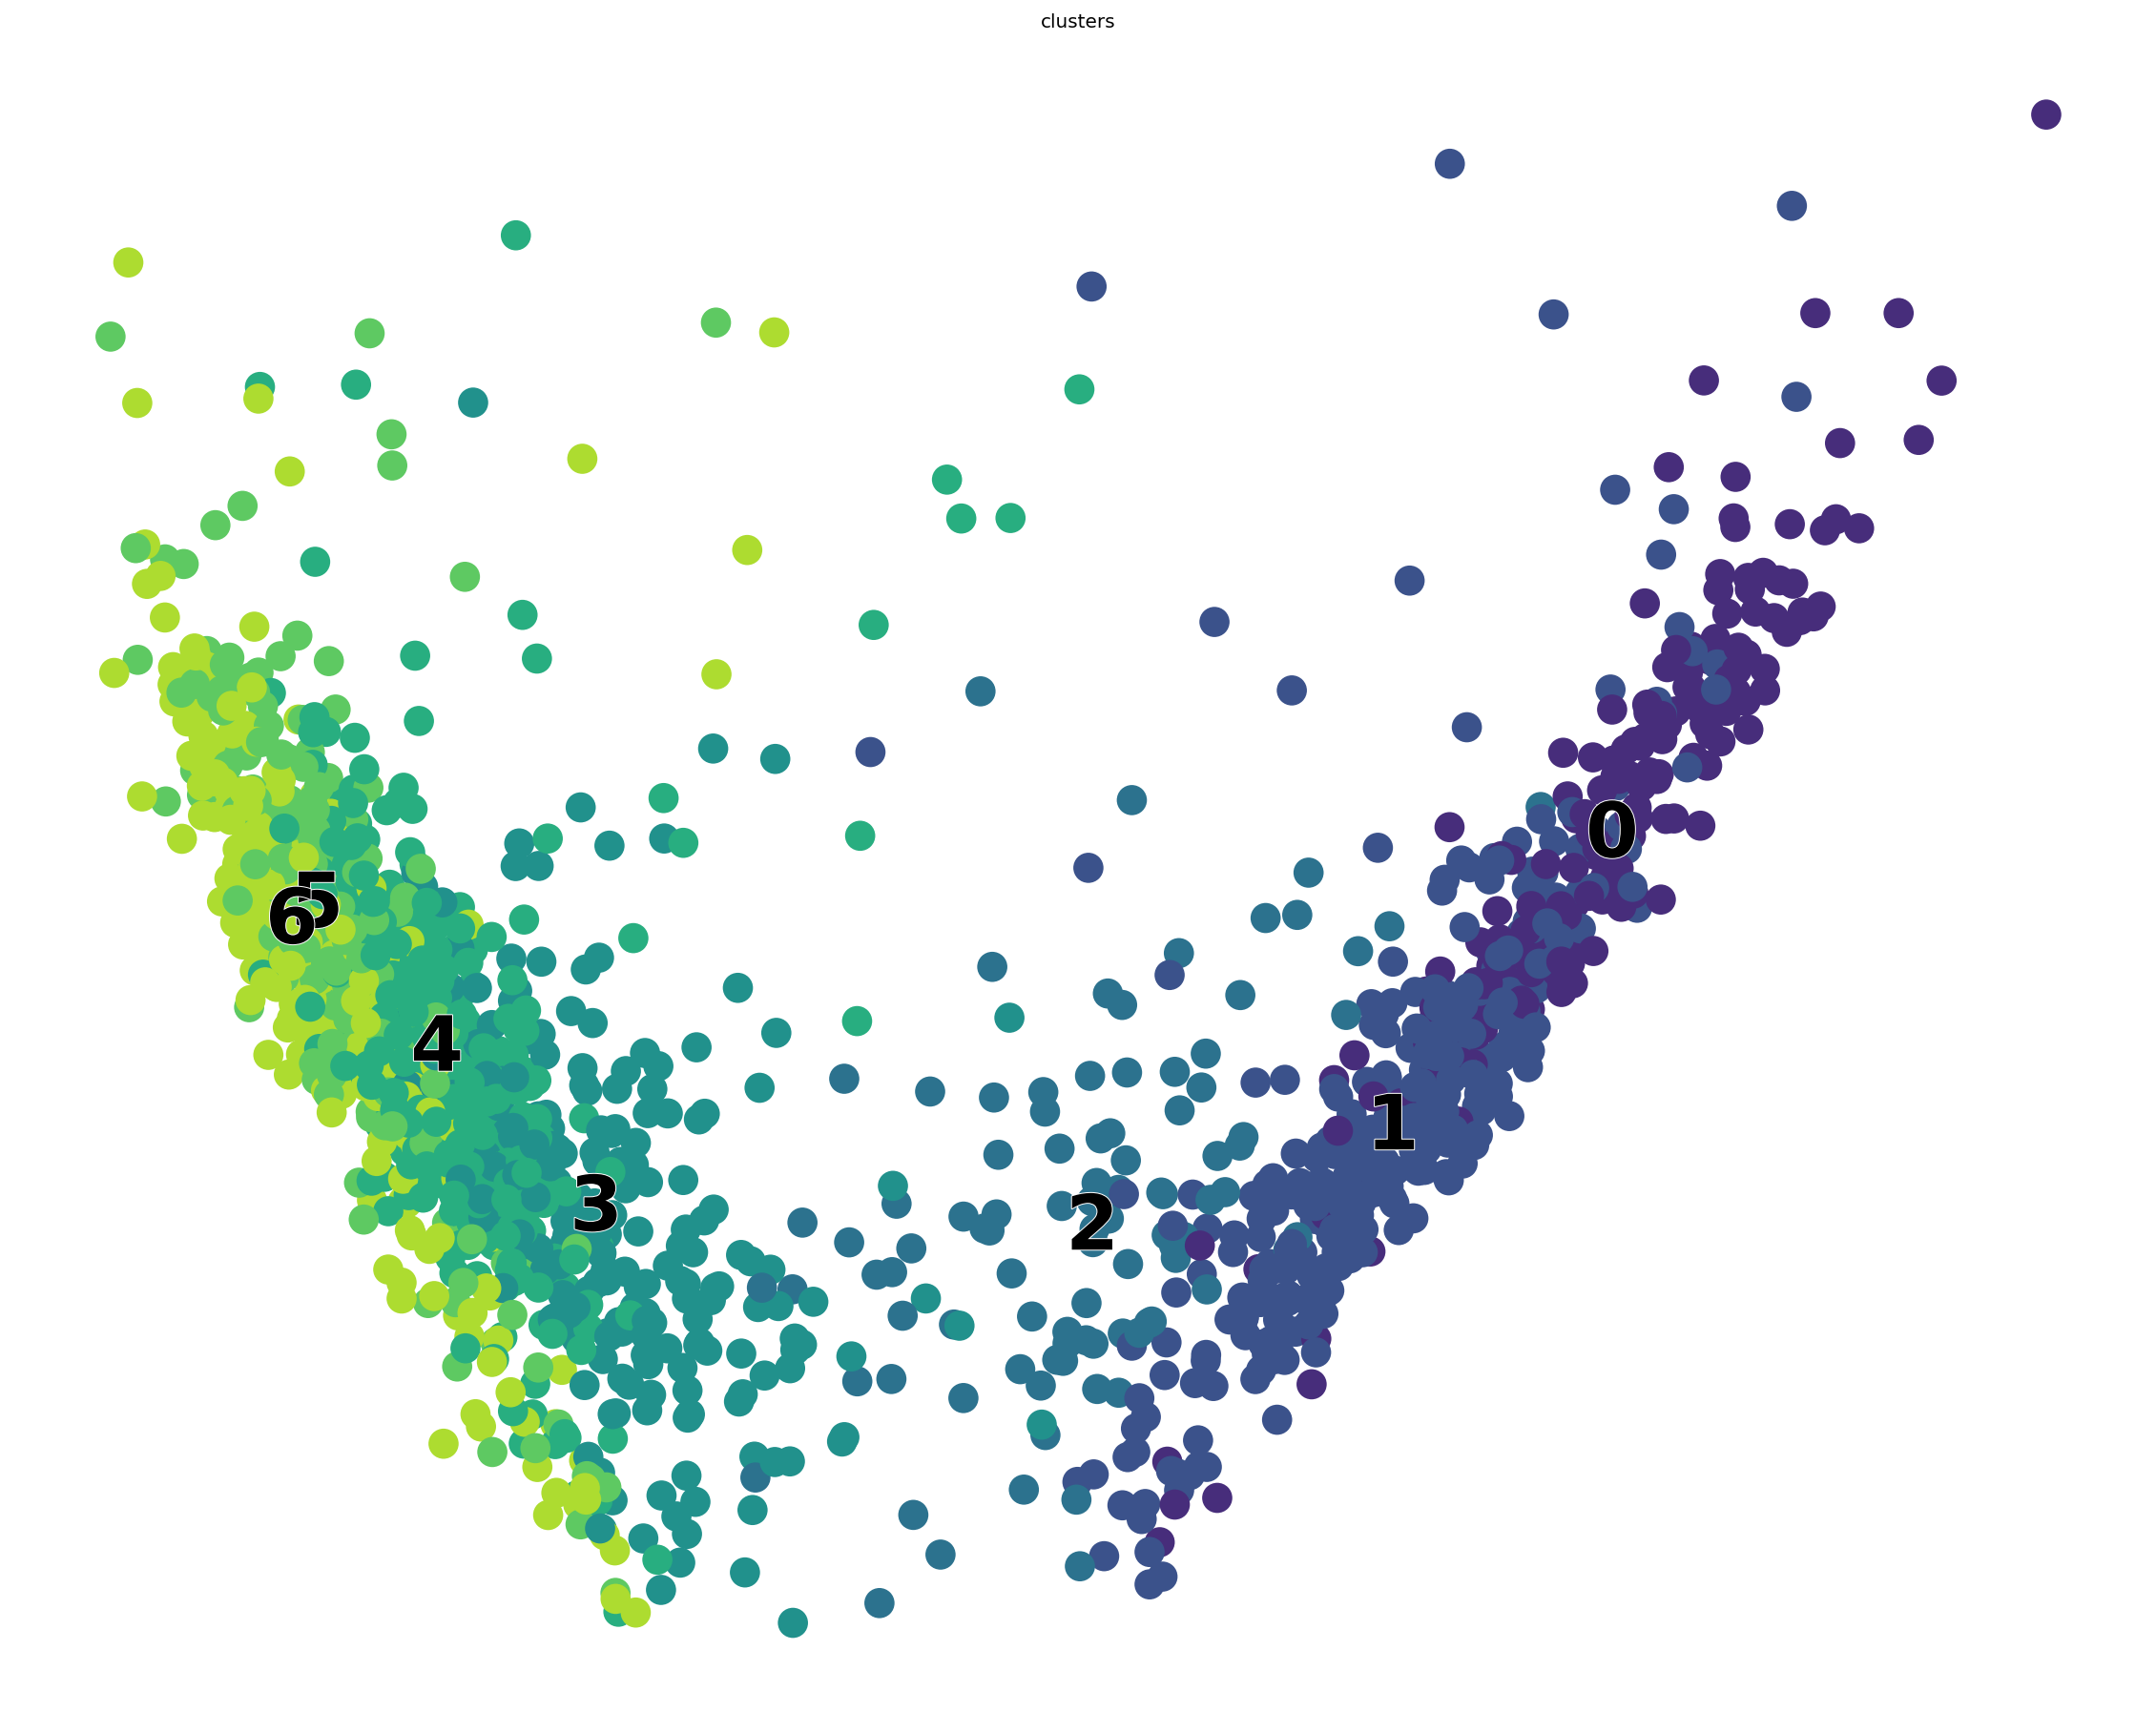

In [96]:
import numpy as np
from matplotlib import colors, cm
vals = np.array(range(adata.obs.Clusters.nunique())) + 1
vals = vals / (vals.max() + 1)
adata.uns['clusters_colors'] = [colors.to_hex(c) for c in cm.get_cmap('viridis')(vals)]

scv.pl.scatter(adata, basis='pca', color="clusters", legend_loc='on data', figsize=(20, 16), size=1000, legend_fontsize=40, save="scvelo_pca_clusters.pdf") # use colormap tab20b

### Compute velocity and velocity graph

In [97]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [98]:
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


#### Project the cvelocity graph onto an embedding

In [99]:
scv.tl.velocity_embedding(adata, basis='pca')

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


2021-02-06 06:28:24,388 - DEBUG - Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021-02-06 06:28:24,390 - DEBUG - Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021-02-06 06:28:24,393 - DEBUG - Writing TrueType font.
saving figure to file ./figures/scvelo_scvelo_velocity.pdf


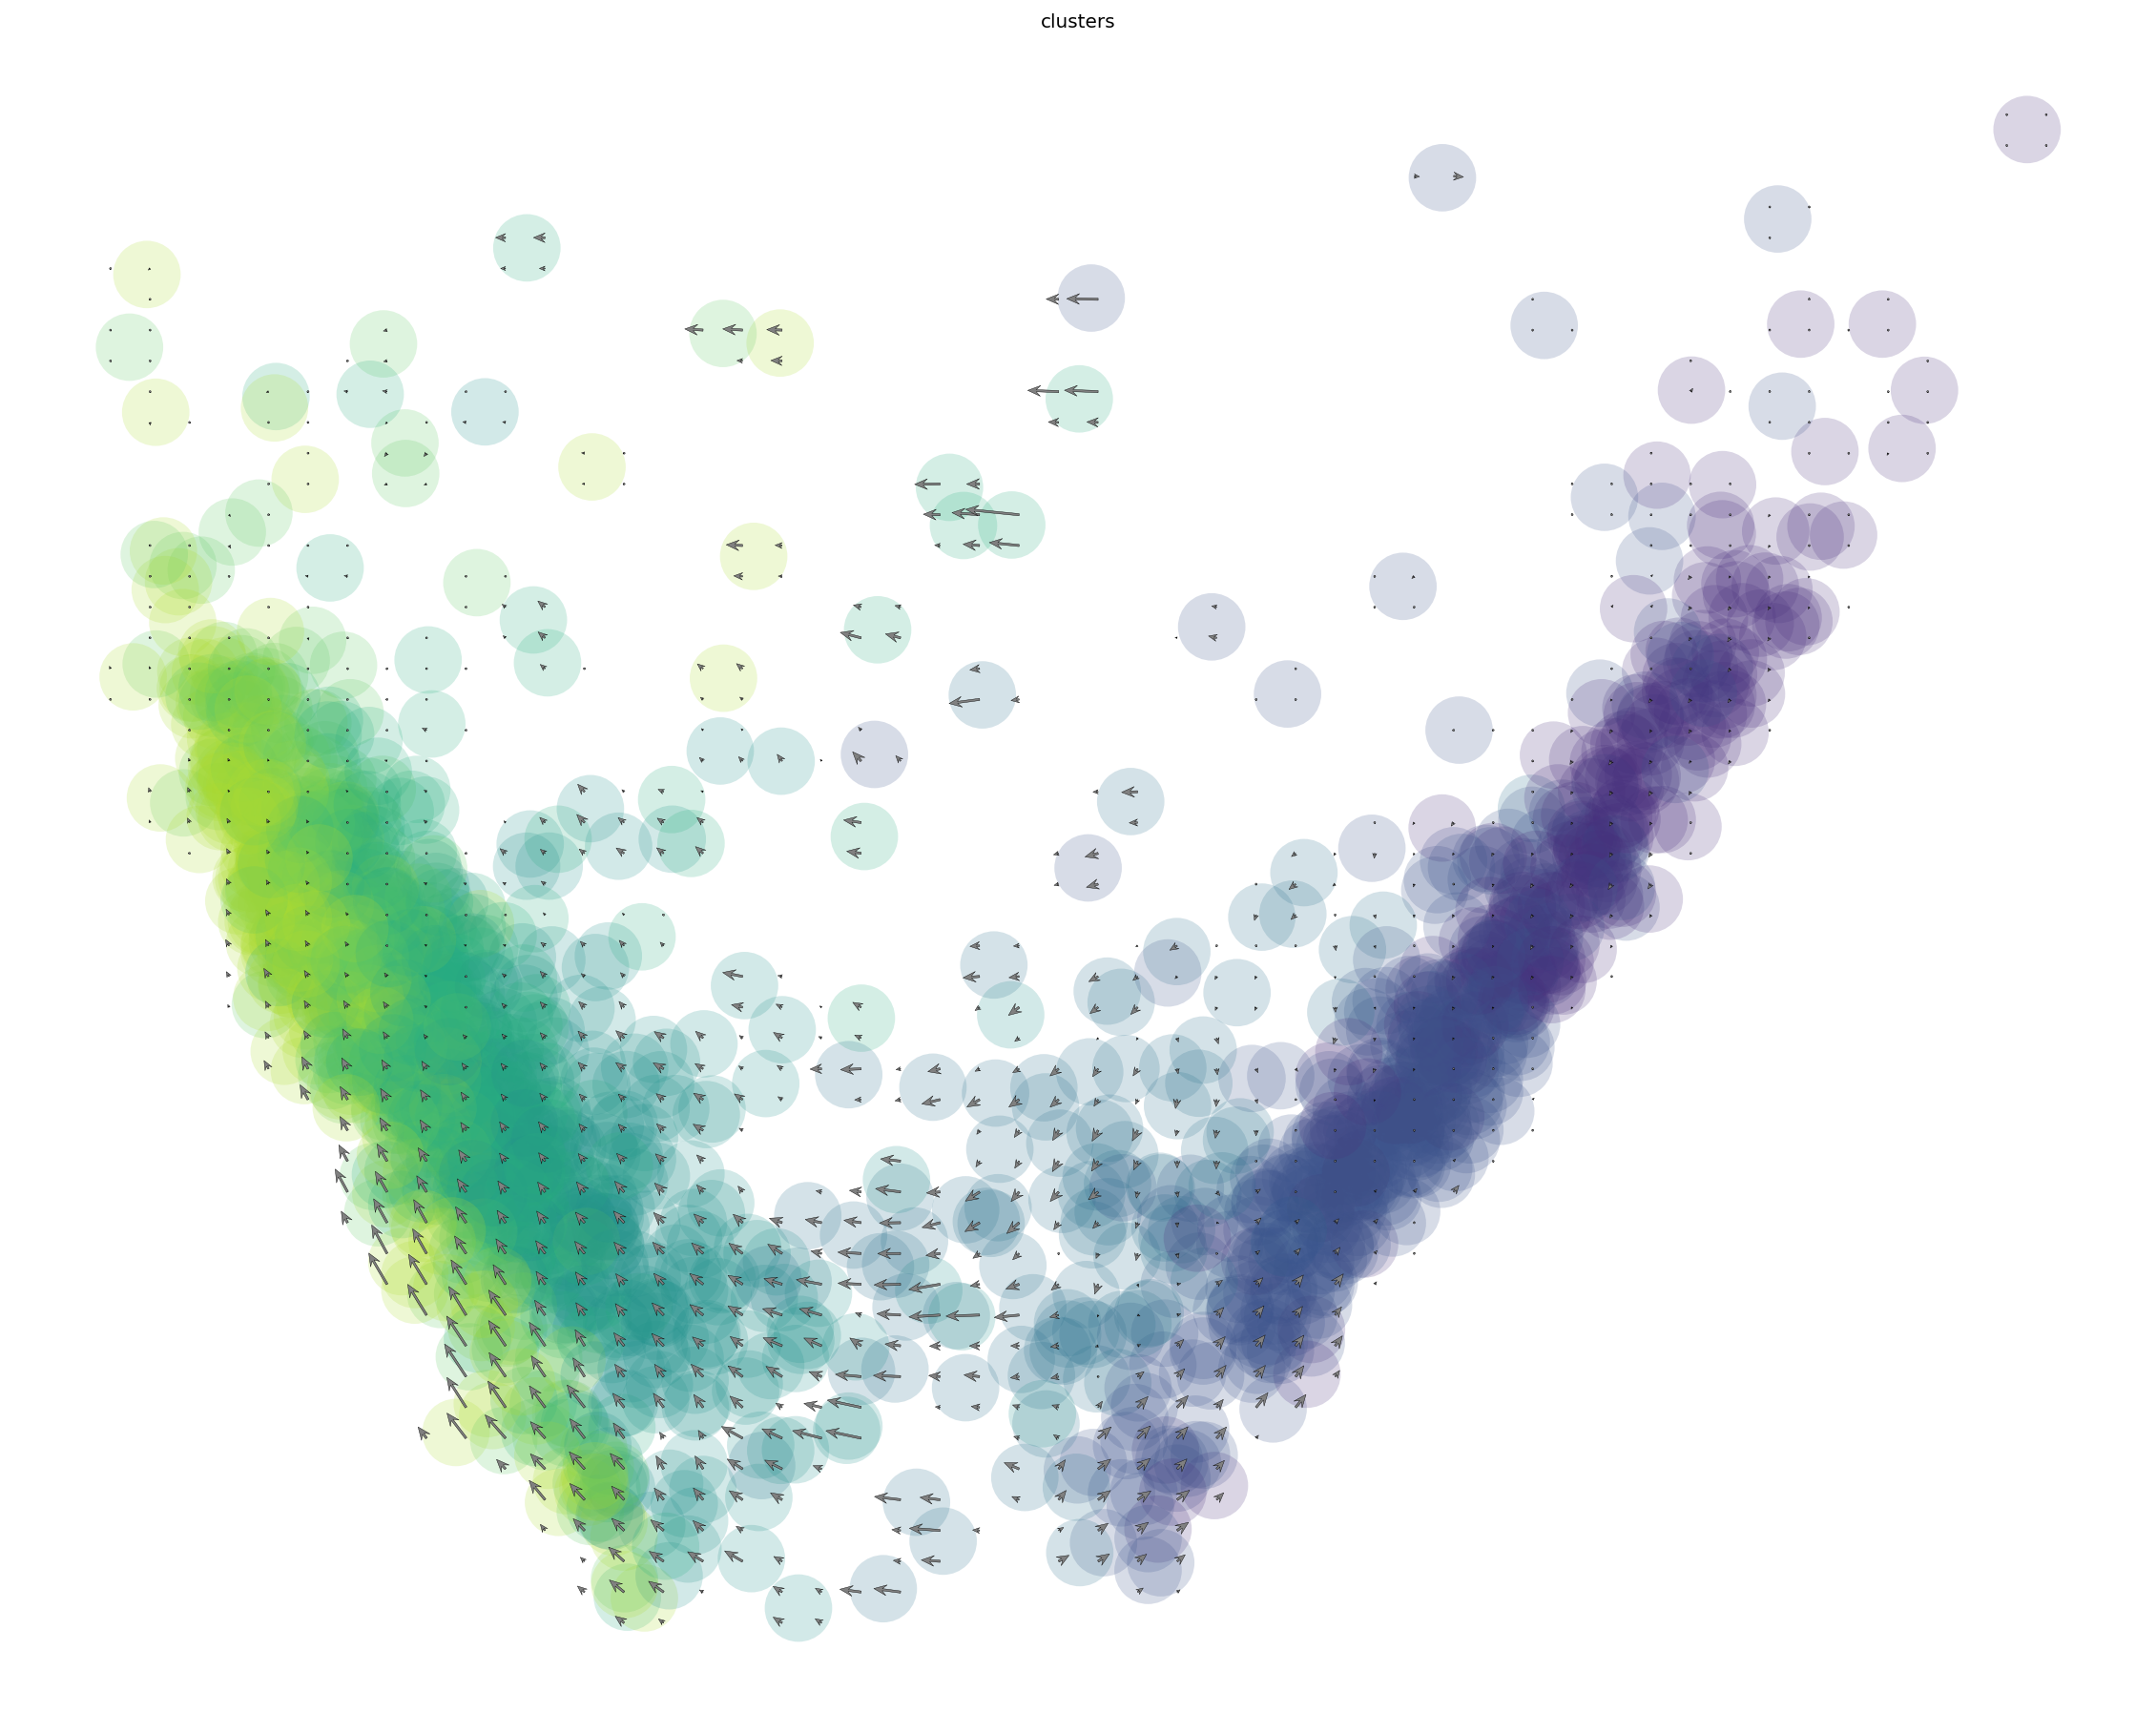

<Figure size 432x288 with 0 Axes>

In [100]:
scv.pl.velocity_embedding_grid(adata, basis='pca', color="clusters", figsize=(20, 16), size=5000, save="scvelo_velocity.pdf")
plt.savefig("scvelo_velocity.pdf")

2021-02-06 06:28:33,999 - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff8fbd59908>
2021-02-06 06:28:34,002 - DEBUG - Using auto colorbar locator on colorbar
2021-02-06 06:28:34,005 - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff8fbd59908>
2021-02-06 06:28:34,008 - DEBUG - Setting pcolormesh
2021-02-06 06:28:34,022 - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff8fbd59908>
2021-02-06 06:28:34,024 - DEBUG - Using auto colorbar locator on colorbar
2021-02-06 06:28:34,025 - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7ff8fbd59908>
2021-02-06 06:28:34,028 - DEBUG - Setting pcolormesh
2021-02-06 06:28:34,033 - DEBUG - locator: <matplotlib.ticker.MaxNLocator object at 0x7ff8fc172ef0>
2021-02-06 06:28:34,037 - DEBUG - Using auto colorbar locator on colorbar
2021-02-06 06:28:34,039 - DEBUG - locator: <matplotlib.ticker.MaxNLocator object at 0x7ff8fc172ef0>
2021-02-06 06:28:34,172 - DE

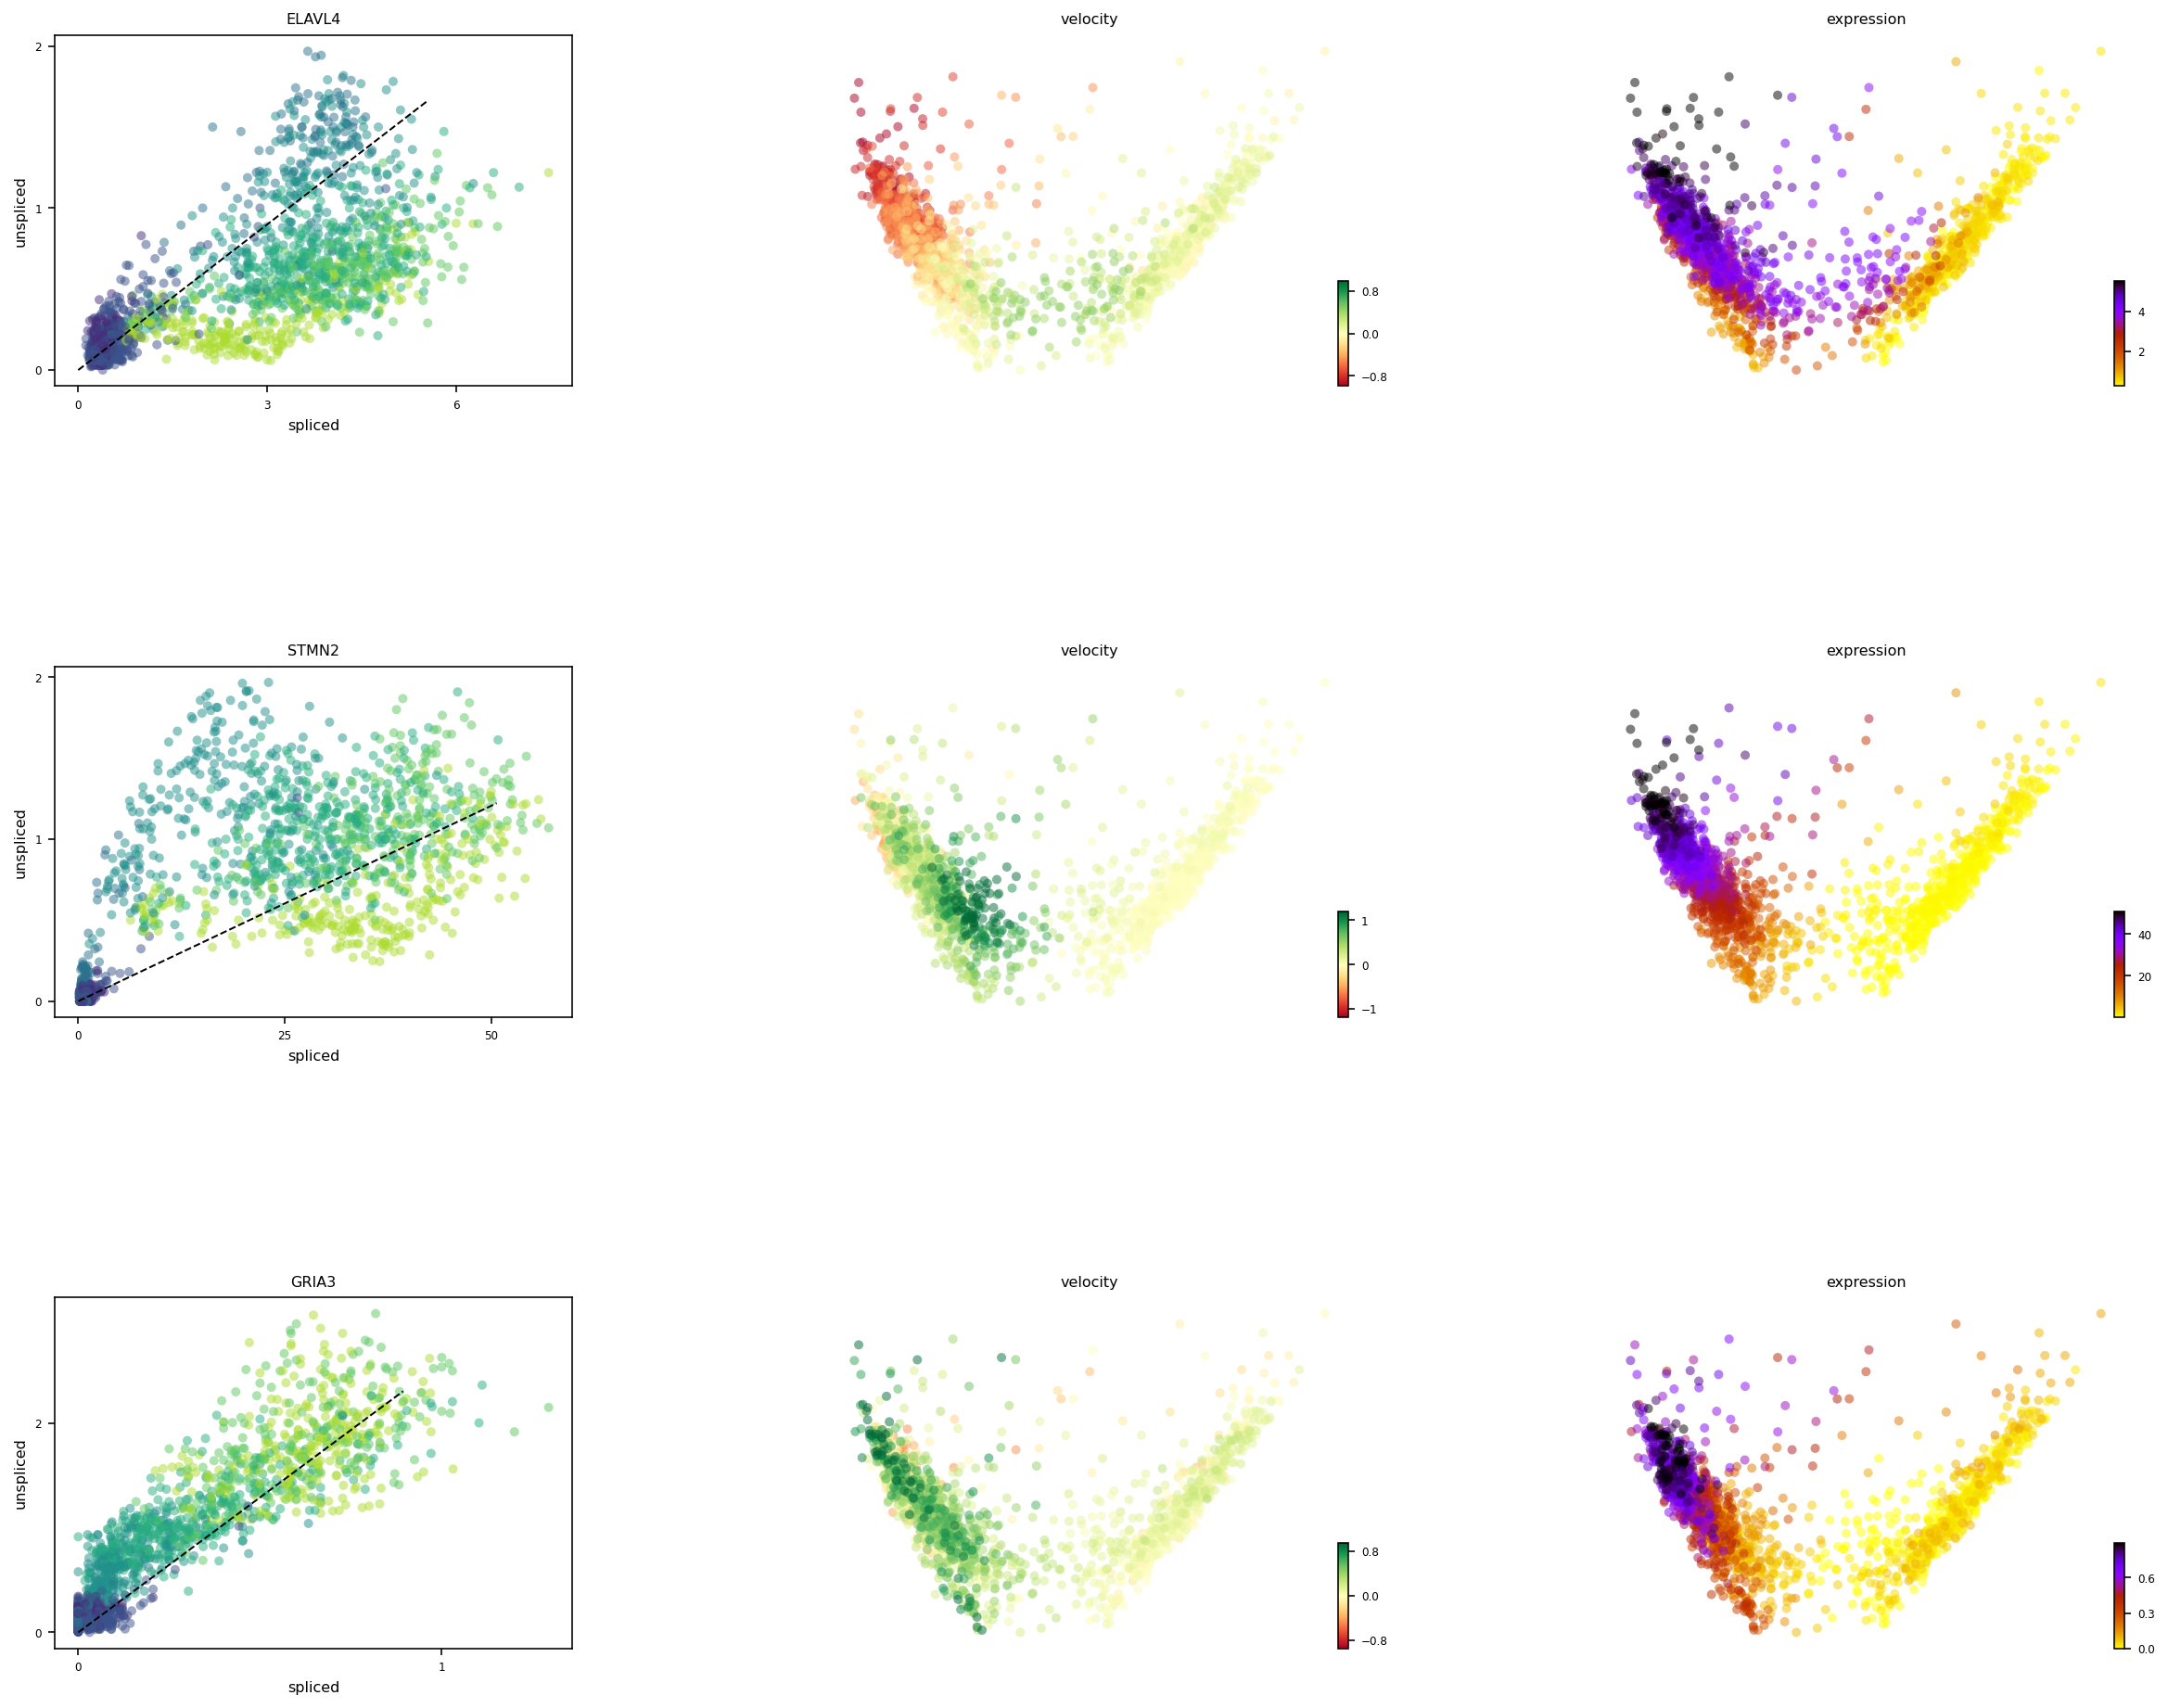

In [101]:
fig, ax = plt.subplots(figsize=(20, 16))
scv.pl.velocity(adata, basis='pca', var_names=["ELAVL4", "STMN2", "GRIA3"], size=100, ax=ax, save="gammas.pdf")
plt.show()

In [102]:
adata

AnnData object with n_obs × n_vars = 1720 × 3002
    obs: 'Clusters', 'bcs', 'sample', 'clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'Accession', 'gid', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'clusters_colors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'velocity_pca'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

## Compare to original

In [109]:
adata = scv.read("test_kallisto.loom", sparse=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [110]:
adata

AnnData object with n_obs × n_vars = 1720 × 31114
    obs: 'Clusters', 'bcs', 'sample'
    var: 'Accession', 'gid'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [111]:
them = scv.read('data/ForebrainGlut/hgForebrainGlut.loom', cleanup=True, sparse=True, cache=True, backup_url='http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom')
them.var_names_make_unique()
them.obs['clusters'] = them.obs['Clusters']

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


In [112]:
them_s = np.array(them.layers["spliced"].sum(axis=1).flatten())[0]
them_u = np.array(them.layers["unspliced"].sum(axis=1).flatten())[0]

In [113]:
adata_s = np.array(adata.layers["spliced"].sum(axis=1).flatten())[0]
adata_u = np.array(adata.layers["unspliced"].sum(axis=1).flatten())[0]

In [114]:
plt.rcParams.update({'font.size': 20})

2021-02-06 06:32:24,128 - DEBUG - Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021-02-06 06:32:24,169 - DEBUG - Assigning font /b'F2' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf'
2021-02-06 06:32:24,268 - DEBUG - Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf.
2021-02-06 06:32:24,269 - DEBUG - Writing TrueType font.
2021-02-06 06:32:24,277 - DEBUG - Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021-02-06 06:32:24,279 - DEBUG - Writing TrueType font.


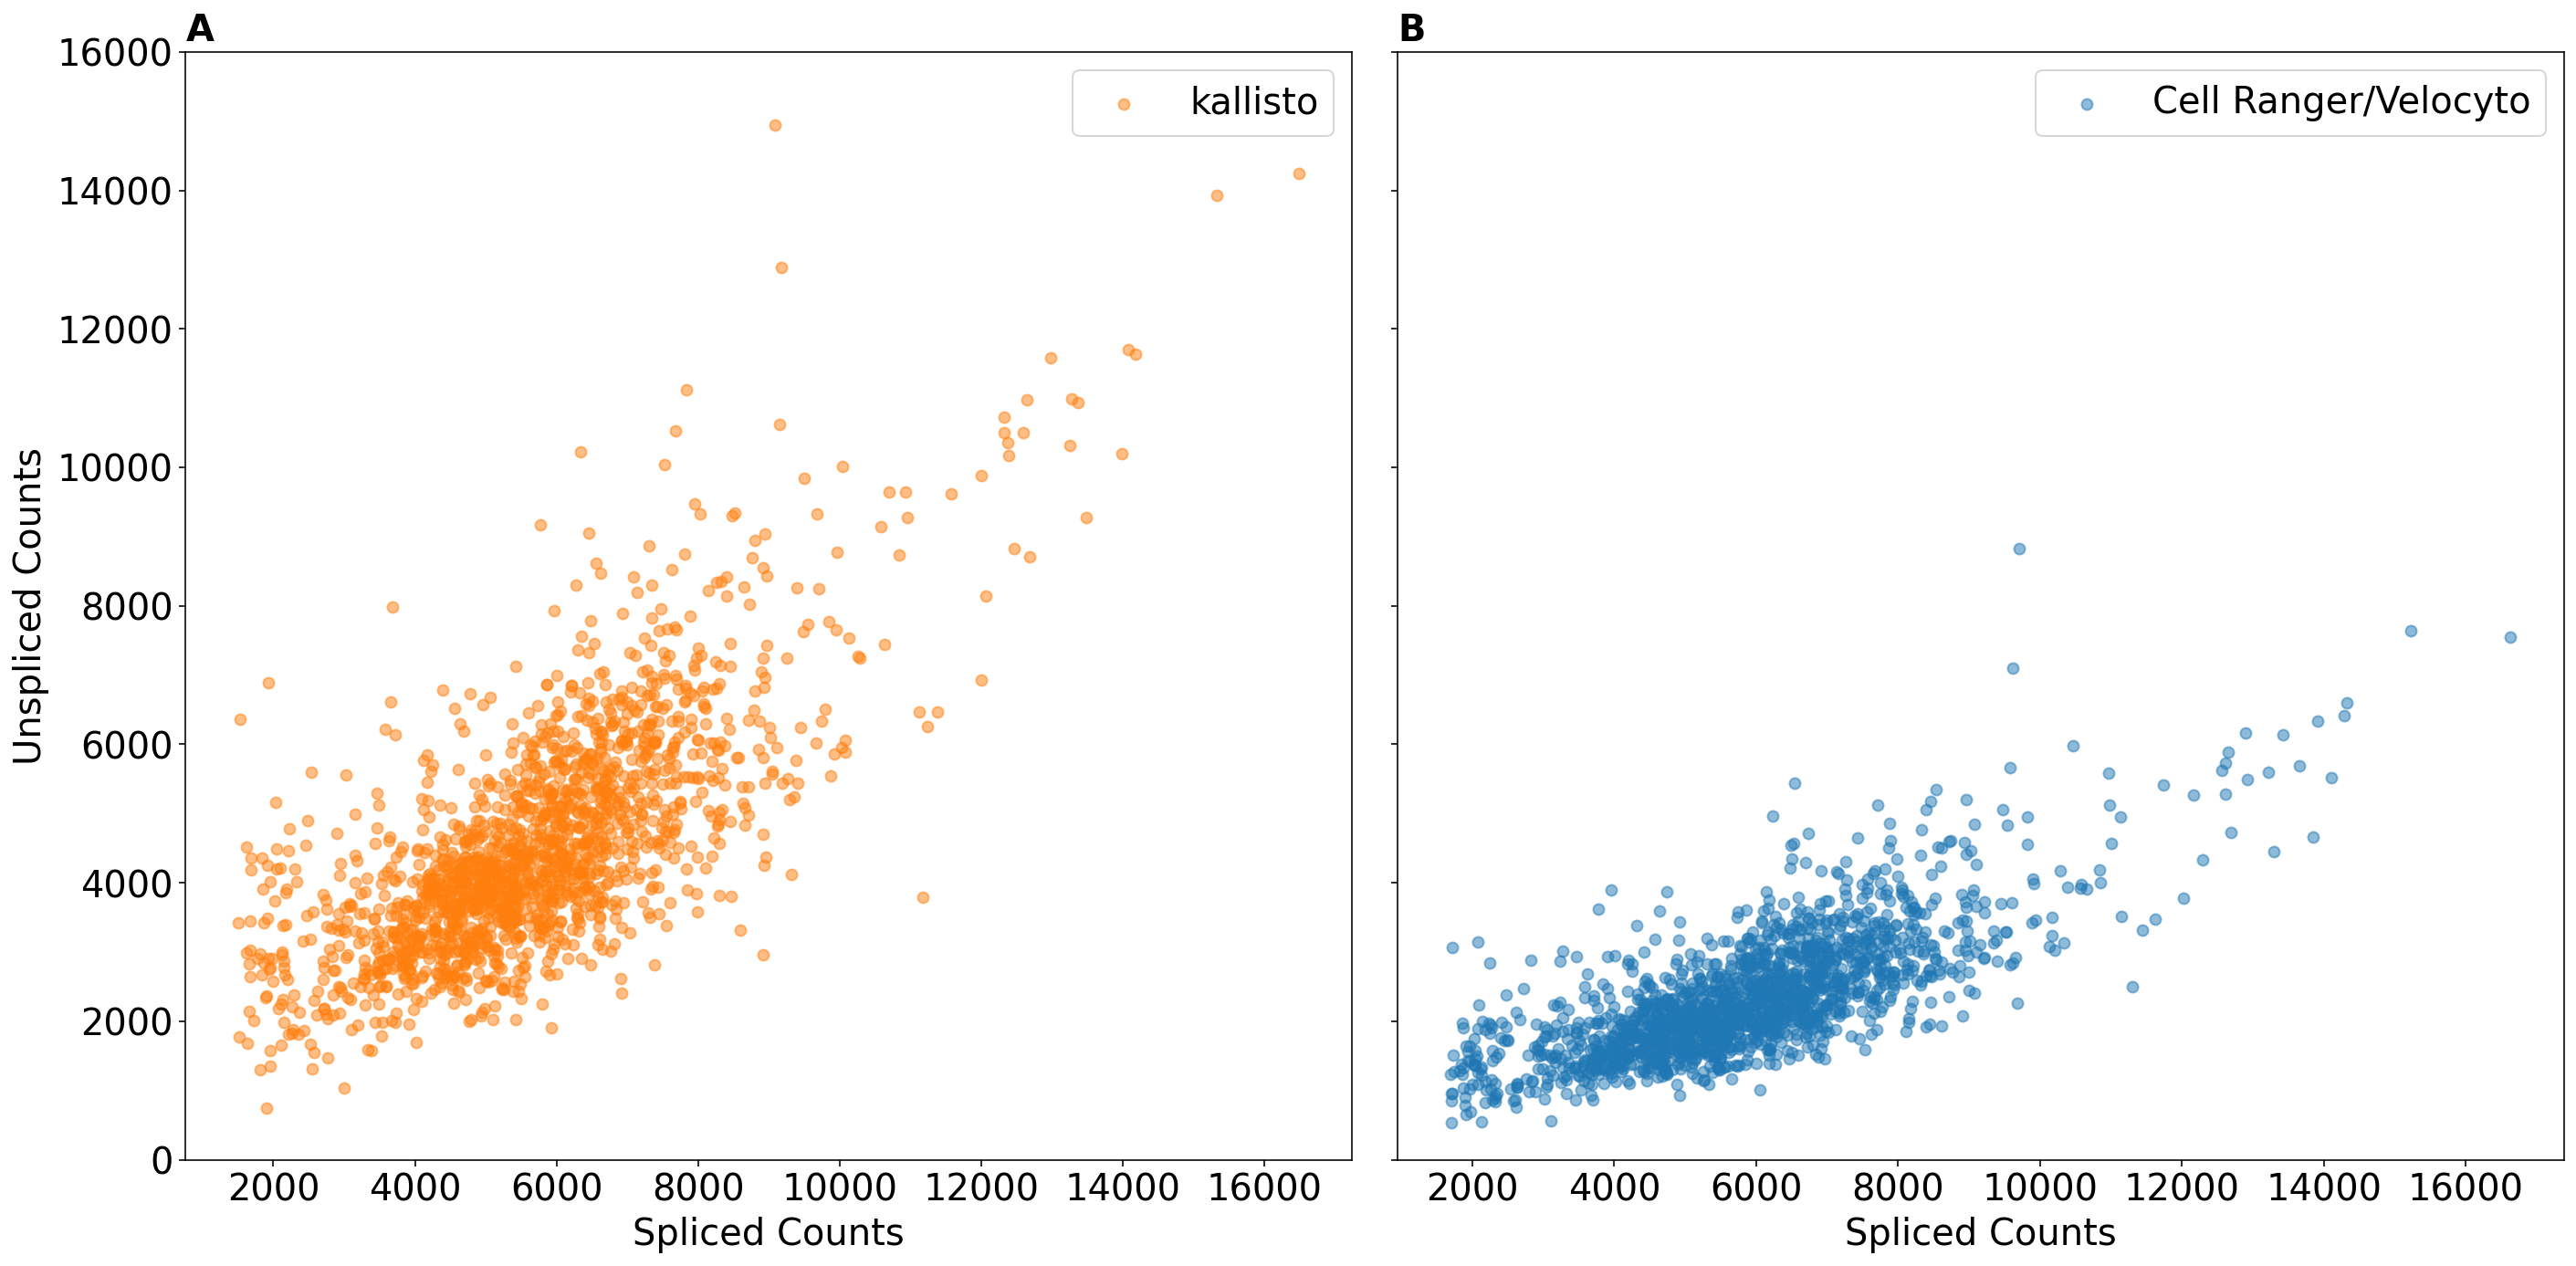

In [115]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=2, sharey=True)

kallisto_color = '#FF7F0E'
tenx_color = '#1F77B4'

ax[0].scatter(adata_s, adata_u, color=kallisto_color, alpha=0.5, label="kallisto")
ax[1].scatter(them_s, them_u, color=tenx_color, alpha=0.5, label="Cell Ranger/Velocyto")

ax[0].set_xlabel("Spliced Counts")
ax[1].set_xlabel("Spliced Counts")

ax[0].set_ylim((0, 16000))
ax[1].set_ylim((0, 16000))
ax[0].set_ylabel("Unspliced Counts")
ax[0].legend()
ax[1].legend()

ax[0].set_title('',loc='center')
ax[0].set_title('A', fontweight='bold', fontsize = 20, loc = 'left' )
ax[1].set_title('',loc='center')
ax[1].set_title('B', fontweight='bold', fontsize = 20, loc = 'left' )
plt.tight_layout()
plt.savefig("spliced_unspliced_comparison.pdf")
plt.show()